<b>Simple script to train Hidden Markov Model for Part of Speech tagging using NLTK</b>

In [1]:
#import the models
import nltk
from nltk import HiddenMarkovModelTagger as hmm # do not use nltk.tag.hmm
from nltk.tokenize import word_tokenize
from nltk.corpus import brown
import warnings
import dill


warnings.filterwarnings('ignore')

<b>Download the data. Run only once</b>

In [2]:
# Ensure the treebank dataset is downloaded
#nltk.download('treebank')
#nltk,download('punkt')
#nltk,download('brown')

<b>Prepare the data. We'll use the Penn Treebank which is an English Corpus that includes pos tagging. For information on the tagset: https://www.sketchengine.eu/penn-treebank-tagset/
We split the data into training and testing. Try to change the data size and experiment with the accuracy change.</b>


In [3]:
print(f'The number of tagged examples in the dataset is: {len(brown.tagged_sents(tagset="universal"))}')
train_data = brown.tagged_sents(tagset='universal')[:50000]
test_data = brown.tagged_sents(tagset='universal')[50000:]

print(f'len of training data is {len(train_data)}')
print(f'len of testing data is {len(test_data)}')
print(train_data[0])

# Extracting unique tags from train_data
unique_tags = set(tag for sent in train_data for _, tag in sent)

print(unique_tags)


The number of tagged examples in the dataset is: 57340
len of training data is 50000
len of testing data is 7340
[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')]
{'PRT', 'PRON', 'ADJ', 'ADV', 'X', '.', 'NUM', 'DET', 'NOUN', 'CONJ', 'ADP', 'VERB'}


<b>Define the trainer and train the model</b>

In [4]:
tagger = hmm.train(train_data, verbose=True)

In [5]:
# Evaluate the model's accuracy on the test data
accuracy = tagger.accuracy(test_data)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.94


<b>Generate true tags list and model prediction to get more detailed stats on where the model performed better and where it didn't perform so well</b>

In [6]:
# Generate Predictions
true_tags = [tag for sent in test_data for _, tag in sent]
predicted_tags = [tag for sent in tagger.tag_sents([[word for word, _ in sent] for sent in test_data]) for _, tag in sent]

In [7]:
# Compute accuracy for each label
labels = list(set(true_tags))
for label in labels:
    correct_predictions = sum(1 for t, p in zip(true_tags, predicted_tags) if t == label and p == label)
    total_predictions = sum(1 for t in true_tags if t == label)
    wrong_predictions = total_predictions - correct_predictions
    label_accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0

    print(f"Label: {label}")
    print(f"Correct Predictions: {correct_predictions}")
    print(f"Wrong Predictions: {wrong_predictions}")
    print(f"Accuracy: {label_accuracy:.2f}\n")

Label: PRT
Correct Predictions: 3655
Wrong Predictions: 597
Accuracy: 0.86

Label: ADJ
Correct Predictions: 6067
Wrong Predictions: 749
Accuracy: 0.89

Label: ADP
Correct Predictions: 11736
Wrong Predictions: 620
Accuracy: 0.95

Label: ADV
Correct Predictions: 6098
Wrong Predictions: 698
Accuracy: 0.90

Label: X
Correct Predictions: 83
Wrong Predictions: 66
Accuracy: 0.56

Label: .
Correct Predictions: 19404
Wrong Predictions: 0
Accuracy: 1.00

Label: NUM
Correct Predictions: 676
Wrong Predictions: 19
Accuracy: 0.97

Label: DET
Correct Predictions: 12911
Wrong Predictions: 364
Accuracy: 0.97

Label: NOUN
Correct Predictions: 19775
Wrong Predictions: 2963
Accuracy: 0.87

Label: CONJ
Correct Predictions: 4152
Wrong Predictions: 7
Accuracy: 1.00

Label: PRON
Correct Predictions: 9128
Wrong Predictions: 119
Accuracy: 0.99

Label: VERB
Correct Predictions: 20255
Wrong Predictions: 1130
Accuracy: 0.95



Confusion Matrix:
       PRT   ADJ    ADP   ADV    X      .  NUM    DET   NOUN  CONJ  PRON  \
PRT   3655     9    367    88    9      1   35      2     30    13    24   
ADJ     11  6067     14   296   44     35   44     63    117    42    25   
ADP    260    21  11736   264    2      0    0     13      4    16    24   
ADV    151   250    146  6098    7     20    8     22     28    26    16   
X        1     7      1     4   83      1   15      1     27     0     6   
.        0     0      0     0    0  19404    0      0      0     0     0   
NUM      0     3      0     2    2      0  676      0     10     0     0   
DET      0     1    131    19    2      0    2  12911      0     3   206   
NOUN   175   434     81   171  186    274  464    258  19775    66   538   
CONJ     0     0      0     4    2      0    0      1      0  4152     0   
PRON     0     0     27     2    0      0    0     83      7     0  9128   
VERB     2   163     93   109   19     78   29     70    466    81    

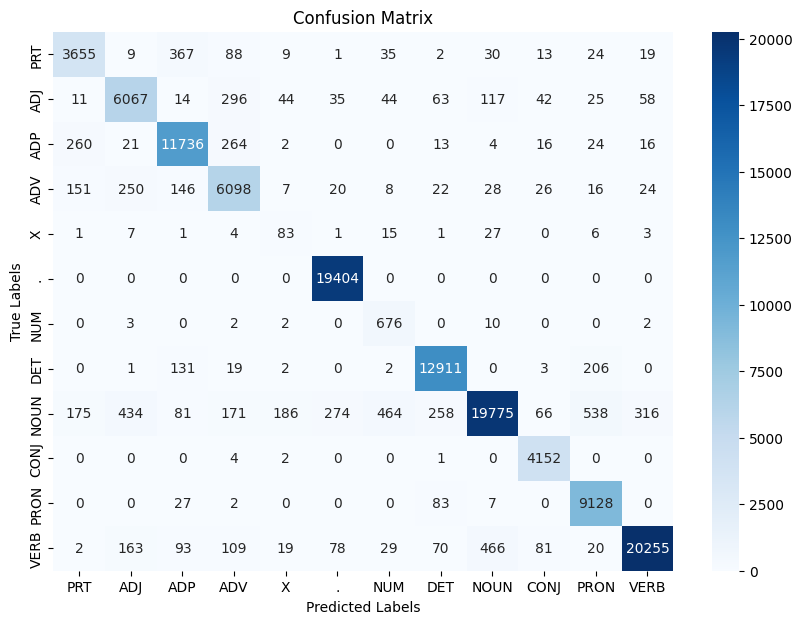

In [8]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_tags, predicted_tags, labels=labels)

# To make the confusion matrix more readable, you can use a DataFrame
conf_matrix_df = pd.DataFrame(conf_matrix, index=labels, columns=labels)

print("Confusion Matrix:")
print(conf_matrix_df)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [9]:
# Dictionary to store examples of incorrect predictions for each label
incorrect_examples = {}

# Generate predicted tags for each sentence in test_data
predicted_tags_sentences = tagger.tag_sents([[word for word, _ in sent] for sent in test_data])

# Iterate through the test data, true tags sentences, and predicted tags sentences
for sent, true_tags_sent, predicted_tags_sent in zip(test_data, test_data, predicted_tags_sentences):
    for (word, true_label), (word_pred, predicted_label) in zip(sent, predicted_tags_sent):
        if true_label != predicted_label:
            # If this label's incorrect prediction hasn't been stored yet, store this example
            if true_label not in incorrect_examples:
                incorrect_examples[true_label] = {
                    'word': word,
                    'true_label': true_label,
                    'predicted_label': predicted_label
                }

# Print the stored examples
for label, example in incorrect_examples.items():
    print(f"Label: {label}")
    print(f"Word: {example['word']}")
    print(f"True Label: {example['true_label']}, Predicted Label: {example['predicted_label']}\n")

Label: PRT
Word: Mmmm
True Label: PRT, Predicted Label: PRON

Label: ADV
Word: sure
True Label: ADV, Predicted Label: ADJ

Label: VERB
Word: itches
True Label: VERB, Predicted Label: NOUN

Label: ADP
Word: so
True Label: ADP, Predicted Label: ADV

Label: ADJ
Word: complete
True Label: ADJ, Predicted Label: VERB

Label: NOUN
Word: sound
True Label: NOUN, Predicted Label: ADJ

Label: DET
Word: that
True Label: DET, Predicted Label: PRON

Label: PRON
Word: her
True Label: PRON, Predicted Label: DET

Label: X
Word: Tchalo
True Label: X, Predicted Label: NUM

Label: NUM
Word: one
True Label: NUM, Predicted Label: NOUN

Label: CONJ
Word: and
True Label: CONJ, Predicted Label: X



<b>If I'm happy with the model, I can save it for later usage</b>

In [10]:
# Save the trained model to a file
with open('hmm_tagger.pkl', 'wb') as f:
    dill.dump(tagger, f)

<b>You can load the model at anytime to use it for tagging sentences</b>

In [11]:
# Load the trained model from the file
with open('hmm_tagger.pkl', 'rb') as f:
    loaded_tagger = dill.load(f)

<b>Try the model on new text</b>

In [12]:
sentence = 'I took the train from Zurich to Italy last night'

tokens = nltk.word_tokenize(sentence)

# Tag the tokenized sentence
tagged_sentence = loaded_tagger.tag(tokens)

print(tagged_sentence)

[('I', 'PRON'), ('took', 'VERB'), ('the', 'DET'), ('train', 'NOUN'), ('from', 'ADP'), ('Zurich', 'NOUN'), ('to', 'ADP'), ('Italy', 'NOUN'), ('last', 'ADJ'), ('night', 'NOUN')]
